# FOR 100 USERS
- For 50 users the accuracy is same for both models

In [ ]:
import numpy as np
from scipy import signal

def resample_emg(single_emg, target_length=1000):
    """
    Resamples EMG signal to a fixed number of time points (target_length).
    Assumes input shape is (8, N), returns shape (8, target_length).
    """
    # Get the current length along axis 1
    current_length = single_emg.shape[1]
    
    # Resample with proper up/down parameters
    return signal.resample_poly(single_emg, target_length, current_length, axis=1)


In [ ]:
import os
import json
import numpy as np

def load_custom_emg_data(dataset_path, max_users=100):
    all_emg_data = []
    labels = []

    for main_folder in ['trainingJSON']:
        folder_path = os.path.join(dataset_path, main_folder)

        user_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
        user_folders = user_folders[:max_users]  # Limit to the first `max_users` folders

        for user_folder in user_folders:
            user_path = os.path.join(folder_path, user_folder)

            for file in os.listdir(user_path):
                if file.endswith('.json'):
                    json_path = os.path.join(user_path, file)
                    with open(json_path, 'r') as f:
                        data = json.load(f)

                    samples = data.get("trainingSamples", {})
                    if(len(samples) == 150):
                        for sample in samples.values():
                            gesture_name = sample.get("gestureName", "unknown")
                            emg = sample.get("emg", {})
    
                            ch_values = [emg.get(f"ch{i+1}", []) for i in range(8)]
                            if all(len(ch) == len(ch_values[0]) for ch in ch_values):  # sanity check
                                if len(ch_values[0]) >= 900:  # assuming your nyquist constraint
                                    emg_matrix = np.array(ch_values)
                                    resampled_matrix = resample_emg(emg_matrix)
                                    all_emg_data.append(resampled_matrix)
                                    labels.append(gesture_name)

    return all_emg_data, labels

# Example usage:
dataset_path = '/kaggle/input/emg-dataset/EMG-EPN612 Dataset'
emg_data, gesture_labels = load_custom_emg_data(dataset_path, max_users=100)

print(f"Loaded {len(emg_data)} gestures")
print(f"Unique gestures: {set(gesture_labels)}")

if emg_data:
    print(f"Sample shape: {emg_data[0].shape}")


In [ ]:
gesture_to_id = {
    "noGesture": 0,       # Example: fist = 0
    "fist": 1,       # open = 1
    "open": 2,      # pinch = 2
    "waveIn": 3,    # wave_in = 3
    "pinch": 4,   # wave_out = 4
    "waveOut": 5  # no_gesture = 5
}
# Convert gesture names to numerical IDs
label_ids = [gesture_to_id[name] for name in gesture_labels]

# Verify
print("First 150 labels:", label_ids[:150])

In [ ]:
import numpy as np
from scipy import signal

def preprocess_emg(single_np_emg, sampling_rate):
    """
    Input: (8, N) - 8 channels, N time points
    Output: (8, N) - preprocessed EMG
    """
    # Bandpass filter (20-450 Hz, 4th order Butterworth)
    lowcut, highcut = 20.0, 450.0
    nyquist = 0.5 * sampling_rate
    b, a = signal.butter(4, [lowcut/nyquist, highcut/nyquist], btype='band')
    
    # Transpose to (N, 8) for filtering
    emg_data_t = single_np_emg.T  # (N, 8)
    filtered_emg = signal.filtfilt(b, a, emg_data_t, axis=0)
    
    # Z-score normalization per channel
    normalized_emg = (filtered_emg - np.mean(filtered_emg, axis=0)) / (np.std(filtered_emg, axis=0) + 1e-8)
    
    return normalized_emg.T  # (8, N)

def preprocess_all_emg_data(emg_data, sampling_rate=1000):
    """
    Input: (num_samples, 8, N)
    Output: (num_samples, 8, N)
    """
    return np.array([preprocess_emg(sample, sampling_rate) for sample in emg_data])

# Usage
preprocessed_emg = preprocess_all_emg_data(emg_data)
print("Preprocessed data shape:", preprocessed_emg.shape)

Preprocessed data shape: (7500, 8, 1000)


In [10]:
print("Mean:", preprocessed_emg.mean())  # Should be ≈0 (normalized)
print("Std:", preprocessed_emg.std())   # Should be ≈1 if z-scored

Mean: -2.335169095128246e-20
Std: 0.9999999973459965


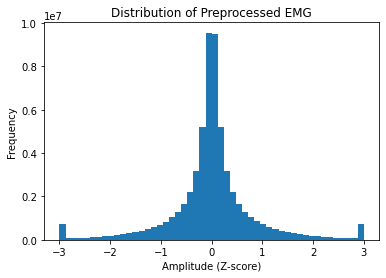

Percentage of outliers (>3σ): 0.00%


In [11]:
preprocessed_emg = np.clip(preprocessed_emg, -3, 3)
import matplotlib.pyplot as plt
plt.hist(preprocessed_emg.flatten(), bins=50)
plt.title("Distribution of Preprocessed EMG")
plt.xlabel("Amplitude (Z-score)"); plt.ylabel("Frequency")
plt.show()

outliers = np.sum(np.abs(preprocessed_emg) > 3) / preprocessed_emg.size * 100
print(f"Percentage of outliers (>3σ): {outliers:.2f}%")

In [ ]:
import numpy as np
from scipy.signal import stft

# Input: preprocessed_emg shape (7500, 8, 1000)
n_samples, n_channels, n_points = preprocessed_emg.shape
sampling_rate = 1000  # Hz

# STFT parameters (adjust based on your needs)
nperseg = 256       # Window length (256 ms)
noverlap = 192      # Overlap (75%)
nfft = 512          # FFT size (zero-padding for better frequency resolution)

# Compute STFT for one example to get the output shape
f, t, Zxx = stft(
    preprocessed_emg[0, 0, :],
    fs=sampling_rate,
    window='hann',
    nperseg=nperseg,
    noverlap=noverlap,
    nfft=nfft,
    return_onesided=True
)

# Initialize output arrays using the actual dimensions from the test run
frequencies = f
time_bins = t
n_freq_bins = f.shape[0]
n_time_bins = t.shape[0]
stft_magnitude = np.zeros((n_samples, n_channels, n_freq_bins, n_time_bins))

# Compute STFT for all samples and channels
for i in range(n_samples):
    for j in range(n_channels):
        _, _, Zxx = stft(
            preprocessed_emg[i, j, :],
            fs=sampling_rate,
            window='hann',
            nperseg=nperseg,
            noverlap=noverlap,
            nfft=nfft,
            return_onesided=True
        )
        stft_magnitude[i, j] = np.abs(Zxx)  # Store magnitude

# Verify shapes
print(f"STFT Magnitude shape: {stft_magnitude.shape}")  # (7500, 8, 257, 17)
print(f"Frequencies shape: {frequencies.shape}")        # (257,)
print(f"Time bins shape: {time_bins.shape}")            # (17,)

STFT Magnitude shape: (7500, 8, 257, 17)
Frequencies shape: (257,)
Time bins shape: (17,)


In [ ]:
import numpy as np
from numba import jit, prange

@jit(nopython=True, parallel=True)
def compute_band_powers(power_spectrum, frequencies, bands):
    """
    Numba-compatible band power computation without np.mean(axis)
    """
    n_samples, n_channels, n_freqs, n_times = power_spectrum.shape
    n_bands = len(bands)
    band_features = np.zeros((n_samples, n_channels, n_bands))
    
    for b in prange(n_bands):  # Parallel loop
        low, high = bands[b]
        count = 0
        
        for s in prange(n_samples):
            for c in range(n_channels):
                total = 0.0
                freq_count = 0
                
                for f in range(n_freqs):
                    if low <= frequencies[f] <= high:
                        # Manual mean calculation over time axis
                        time_sum = 0.0
                        for t in range(n_times):
                            time_sum += power_spectrum[s, c, f, t]
                        total += time_sum / n_times
                        freq_count += 1
                
                if freq_count > 0:
                    band_features[s, c, b] = total / freq_count
    
    return band_features

def extract_6class_emg_features_optimized(stft_magnitude, frequencies, fs=1000):
    """
    Fully working version with all fixes applied
    """
    n_samples, n_channels, n_freqs, n_times = stft_magnitude.shape

    # 1. Power spectrum (vectorized)
    power_spectrum = np.square(stft_magnitude)
    total_power = np.sum(power_spectrum, axis=2)  # shape: (n_samples, n_channels, n_times)

    # 2. Mean frequency (vectorized)
    weighted_sum = np.sum(power_spectrum * frequencies[None, None, :, None], axis=2)
    mean_freq = weighted_sum / (total_power + 1e-10)

    # 3. Median frequency (fixed broadcasting)
    cumsum = np.cumsum(power_spectrum, axis=2)  # shape: (n_samples, n_channels, n_freqs, n_times)
    half_power = 0.5 * total_power[:, :, None, :]  # shape: (n_samples, n_channels, 1, n_times)
    
    # Find median frequency indices
    median_freq_idx = np.empty((n_samples, n_channels, n_times), dtype=np.int64)
    for s in range(n_samples):
        for c in range(n_channels):
            for t in range(n_times):
                median_freq_idx[s, c, t] = np.argmax(cumsum[s, c, :, t] >= half_power[s, c, 0, t])
    
    median_freq = frequencies[median_freq_idx]

    # 4. Spectral entropy (vectorized)
    prob = power_spectrum / (total_power[:, :, None, :] + 1e-10)
    entropy = -np.sum(prob * np.log2(prob + 1e-10), axis=2)

    # 5. Band powers (using fixed computation)
    bands = [(20, 50), (50, 100), (100, 150), (150, 250), (250, 350), (350, 500)]
    band_powers = compute_band_powers(power_spectrum, frequencies, bands)

    # 6. Time aggregation
    features = np.stack([mean_freq, median_freq, total_power, entropy], axis=-1)
    features_mean = np.mean(features, axis=2)
    features_std = np.std(features, axis=2)

    # 7. Channel correlations (vectorized)
    stft_db = 20 * np.log10(stft_magnitude + 1e-10)
    stft_flat = stft_db.reshape(n_samples, n_channels, -1)
    corr_features = np.zeros((n_samples, n_channels * (n_channels - 1) // 2))
    
    for s in range(n_samples):
        corr_matrix = np.corrcoef(stft_flat[s])
        corr_features[s] = corr_matrix[np.triu_indices(n_channels, k=1)]

    # 8. Final feature matrix
    X = np.hstack([
        features_mean.reshape(n_samples, -1),
        features_std.reshape(n_samples, -1),
        band_powers.reshape(n_samples, -1),
        corr_features
    ])

    return X

In [ ]:
stft_magnitude = np.load("./variables/stft_magnitude.npy")
frequencies = np.load("./variables/frequencies.npy")

features = extract_6class_emg_features_optimized(stft_magnitude, frequencies, fs=1000)

In [ ]:
features.shape

In [ ]:
y = label_ids

# MODEL 1 - 89% Accuracy - RF Model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features,  # or X_reduced if using feature selection
    y,
    test_size=0.2,
    random_state=42
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Test accuracy:", clf.score(X_test, y_test))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# MODEL 2 - 92.01% Accuracy (1D CNN)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Reshape features to (samples, timesteps, channels)
X_reshaped = features.reshape(-1, 140, 1)  # Treat each feature as a timestep

# Convert labels to one-hot encoding
y_onehot = to_categorical(y)  # Assuming y contains class indices 0-5

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_onehot, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Flatten, scale, then reshape back
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 140)).reshape(-1, 140, 1)
X_test_scaled = scaler.transform(X_test.reshape(-1, 140)).reshape(-1, 140, 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    # Feature extraction block
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(140, 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # Second convolution block
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    # Classifier
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 gesture classes
])

# Compile with custom learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions (convert from one-hot to class indices)
y_pred = model.predict(X_test_scaled).argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Generate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                            display_labels=["noGesture", "fist", "open", "waveIn", "pinch", "waveOut"])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('EMG Gesture Confusion Matrix')
plt.tight_layout()
plt.show()